In [1]:
###Steam spy for college writing

import requests
import pandas as pd
import random
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Define the base URL for the Steam Spy API
base_url = "https://steamspy.com/api.php"


In [ ]:
def fetch_indie_games():
    response = requests.get(f"{base_url}?request=genre&genre=Indie")
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Error: Unable to fetch data (status code: {response.status_code})")
        return None

def fetch_app_details(appid):
    response = requests.get(f"{base_url}?request=appdetails&appid={appid}")
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: Unable to fetch details for appid {appid} (status code: {response.status_code})")
        return None

In [ ]:
# Fetch the indie games data
indie_games = fetch_indie_games()

In [ ]:
# Check if data was fetched successfully
if indie_games:
    # Transform the data into a DataFrame
    indie_df = pd.DataFrame.from_dict(indie_games, orient='index')
    # indie_df.summarize()
    # Clean and process the data
    indie_df['owners'] = (
    indie_df['owners']
    .astype(str)  # Ensure the data is a string
    .str.replace(',', '')  # Remove commas
    .str.split(' .. ')  # Split the range
    .apply(lambda x: (int(x[0]) + int(x[1])) // 2 if isinstance(x, list) and len(x) == 2 else None)  # Calculate the average
    )
    indie_df['price_usd'] = indie_df['price'].astype(int)  / 100
    indie_df['average_forever_hours'] = indie_df['average_forever'] / 60
    indie_df['average_2weeks_hours'] = indie_df['average_2weeks'] / 60
   
    # Display summary statistics
    print("Summary Statistics for Indie Games:")
    print(f"Total number of games: {len(indie_df)}")
    print(f"Average Price (USD): {indie_df['price_usd'].mean():.2f}")
    print(f"Average Owners: {indie_df['owners'].mean():.0f}")
    print(f"Average Playtime (Forever): {indie_df['average_forever_hours'].mean():.2f} hours")
    print(f"Average Playtime (Last 2 Weeks): {indie_df['average_2weeks_hours'].mean():.2f} hours")
else:
    print("No data available.")

In [ ]:
if indie_games:
    indie_df.to_csv("./indie_games_summary.csv", index=False)
    print("Data saved to 'indie_games_summary.csv'.")

In [ ]:
if not indie_df.empty:
    # Pick a random appid from the existing data
    random_appid = random.choice(indie_df.index)
    print(f"Fetching details for AppID: {random_appid}")
    
    # Fetch the detailed data
    app_details = fetch_app_details(random_appid)
    
    # Display the details
    if app_details:
        print("App Details:")
        for key, value in app_details.items():
            print(f"{key}: {value}")
else:
    print("The DataFrame is empty. Cannot pick a random app.")

In [ ]:
# driver_path = "/chromedriver-win64/chromedriver-win64/chromedriver.exe"  # Replace with your ChromeDriver path
url = "https://www.steamspy.com/genre/Indie"  # Replace with the actual page URL


#Use BS4

In [ ]:
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Locate the table (Inspect the page for the exact class or ID)
    table = soup.find('table')  # Add class or ID if needed, e.g., find('table', {'class': 'table-class'})
    
    if table:
        # Extract table headers
        headers = [header.text.strip() for header in table.find_all('th')]
        
        # Extract table rows
        rows = []
        for row in table.find_all('tr')[1:]:  # Skip the header row
            cells = row.find_all('td')
            rows.append([cell.text.strip() for cell in cells])
        
        # Create a pandas DataFrame
        data = pd.DataFrame(rows, columns=headers)
        print("Data scraped successfully!")
        
        # Save to CSV
        data.to_csv("steamspy_table.csv", index=False)
        print("Data saved to 'steamspy_table.csv'.")
    else:
        print("Table not found on the page.")
else:
    print(f"Failed to fetch the webpage (status code: {response.status_code}).")

In [94]:
#clean data
data = pd.read_csv("../steamspy_table.csv")

#Remove corrupt rows
# print(data.info())
data = data.dropna()
print(data.info())

# get average owners
data['Owners'] = (
    data['Owners']
    .astype(str)  # Ensure the data is a string
    .str.replace(',', '')  # Remove commas
    .str.split(" .. ")  # Split the range
    .apply(lambda x: (int(x[0]) + int(x[1])) // 2 if isinstance(x, list) and len(x) == 2 else None)  # Calculate the average
    )
# play time as median play time in seconds
data['Median Playtime (sec)'] = data['Playtime (Median)'].str.extract(r'\((.*?)\)').astype(str)
data['Median Playtime (sec)'] = data['Median Playtime (sec)'].apply(
    lambda x: int(x.split(':')[0])*60 + int(x.split(":")[1]) ).astype(int)

# score rank extraction
data['Metascore'] = data['Score rank(Userscore / Metascore)'].str.extract(r'\((?:.*/)?(\d+)%?\)')

# price extraction
data['Price'] = data['Price'].str.extract(r'(\d+)').astype(float)

# release date extraction in to year and month
data['Release date'] = pd.to_datetime(data['Release date'], format='mixed', errors='coerce')

# Remove unwanted columns
data = data.drop(columns=['Score rank(Userscore / Metascore)', 'Playtime (Median)'])

print(data.head(5))

#Save the cleaned data to a new CSV file
data.to_csv("steamspy_crawl_table_cleaned.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 58493 entries, 0 to 60963
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   #                                  58493 non-null  int64 
 1   Game                               58493 non-null  object
 2   Release date                       58493 non-null  object
 3   Price                              58493 non-null  object
 4   Score rank(Userscore / Metascore)  58493 non-null  object
 5   Owners                             58493 non-null  object
 6   Playtime (Median)                  58493 non-null  object
 7   Developer(s)                       58493 non-null  object
 8   Publisher(s)                       58493 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.5+ MB
None
   #                                       Game Release date  Price   Owners  \
0  1                                Cobalt Core   2023-11-08   14.0  

C:\Users\jakej\AppData\Local\Temp\ipykernel_44916\3253419103.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').size().reset_index(name='game_count')


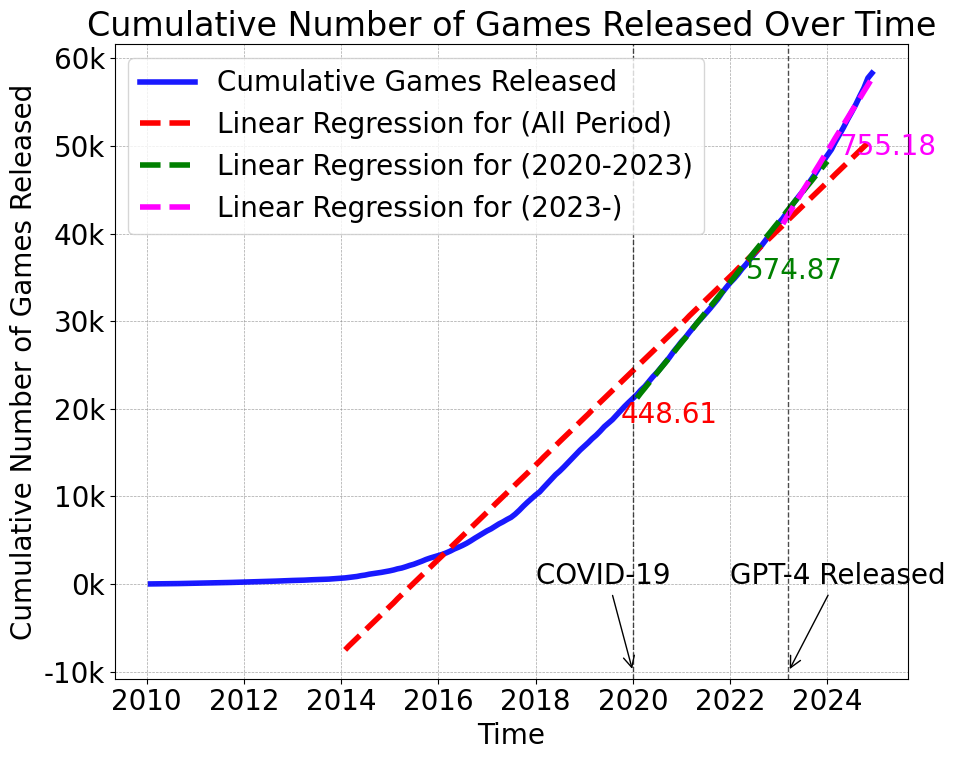

In [28]:
#make publish date plot
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np


df = pd.read_csv("steamspy_crawl_table_cleaned.csv")

# Filter data from 2004 onwards
df['Release date'] = pd.to_datetime(df['Release date'])
df = df[df['Release date'].dt.year >= 2010]

df['Release date'] = pd.to_datetime(df['Release date'])

# Set Release date as the index
df.set_index('Release date', inplace=True)

# Count the number of elements per month
df_monthly = df.resample('M').size().reset_index(name='game_count')

# Compute the cumulative total
df_monthly['cumulative_games'] = df_monthly['game_count'].cumsum()

# Create a function to fit and plot linear regression
def plot_with_regression_cumulative(df, label, color, start_date=None, end_date=None):
    # Filter data by date range
    filtered_df = df[(df['Release date'] >= start_date) & (df['Release date'] <= end_date)] if start_date and end_date else df
    x = np.arange(len(filtered_df)).reshape(-1, 1)  # Convert index to sequential numbers
    y = filtered_df['cumulative_games'].values.reshape(-1, 1)

    # Fit the regression model
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0][0]
    mid_date = filtered_df['Release date'].iloc[len(filtered_df) // 2]
    mid_cumulative = filtered_df['cumulative_games'].iloc[len(filtered_df) // 2]
    plt.text(mid_date+pd.Timedelta(days=90), mid_cumulative, f"{slope:.2f}", color=color, fontsize=20)
    # Plot the regression line
    plt.plot(filtered_df['Release date'], y_pred, label=f"Linear Regression for ({label})", color=color, linestyle="--",linewidth=4)

plt.rcParams.update({'font.size': 20})
# Plot the cumulative data
plt.figure(figsize=(10, 8))
plt.plot(df_monthly['Release date'], df_monthly['cumulative_games'], label="Cumulative Games Released", color="blue", alpha=0.9, linewidth=4)
from matplotlib.ticker import FuncFormatter
def yaxis_formatter(x, _):
    return f"{x / 1000:.0f}k"  # Convert to thousands
plt.gca().yaxis.set_major_formatter(FuncFormatter(yaxis_formatter))
# Plot regression lines
plot_with_regression_cumulative(df_monthly, "All Period", "red", "2014-01-01", "2024-12-31")
plot_with_regression_cumulative(df_monthly, "2020-2023", "green", "2020-01-01", "2023-12-31")
plot_with_regression_cumulative(df_monthly, "2023-", "magenta", "2023-01-01", "2024-12-31")

# Formatting the plot
plt.title("Cumulative Number of Games Released Over Time")
plt.xlabel("Time")
plt.ylabel("Cumulative Number of Games Released")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.annotate(
    'COVID-19 ', 
    xy=(pd.Timestamp('2020-01-01'), -10000),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2018-01-01'), 0),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=20
)
plt.annotate(
    'GPT-4 Released', 
    xy=(pd.Timestamp('2023-03-14'), -10000),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2022-01-01'), 0),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=20
)
plt.axvline(x=pd.Timestamp('2020-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(x=pd.Timestamp('2023-03-14'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.tight_layout()

#save the plot
plt.savefig("cumulative_games_released.png", dpi=300, bbox_inches='tight')


# Show the plot
plt.show()



<class 'pandas.core.frame.DataFrame'>
Index: 2140 entries, 0 to 49402
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   #                      2140 non-null   int64         
 1   Game                   2140 non-null   object        
 2   Release date           2140 non-null   datetime64[ns]
 3   Price                  2100 non-null   float64       
 4   Owners                 2140 non-null   int64         
 5   Developer(s)           2140 non-null   object        
 6   Publisher(s)           2140 non-null   object        
 7   Median Playtime (sec)  2140 non-null   int64         
 8   Metascore              2140 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 167.2+ KB
None
  Release date  Metascore
0   2010-12-31  72.750000
1   2011-12-31  71.950820
2   2012-12-31  73.300000
3   2013-12-31  72.069767
4   2014-12-31  69.795699
5   2

C:\Users\jakej\AppData\Local\Temp\ipykernel_44916\3867288402.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_monthly = df.resample('Y')['Metascore'].mean().reset_index(name='Metascore')


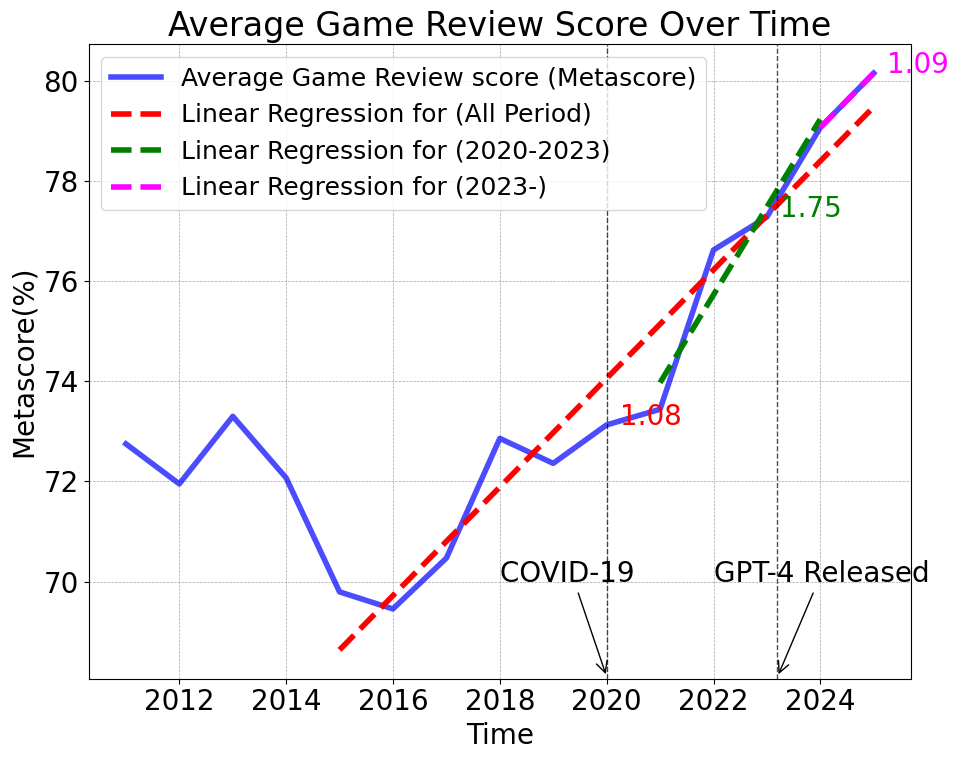

In [35]:
df = pd.read_csv("steamspy_crawl_table_cleaned.csv")

# Filter data from 2004 onwards
df['Release date'] = pd.to_datetime(df['Release date'])
df = df[df['Release date'].dt.year >= 2010]
# drop rows with null Metascore
df = df.dropna(subset=['Metascore'])

df['Release date'] = pd.to_datetime(df['Release date'])
print(df.info())


# Set Release date as the index
df.set_index('Release date', inplace=True)

# Count the number of elements per month
df_monthly = df.resample('Y')['Metascore'].mean().reset_index(name='Metascore')
df_monthly = df_monthly.dropna()

# Compute the cumulative total
# df_monthly['average game score'] = df_monthly['Metascore'].mean()
print(df_monthly.head(10))
# Create a function to fit and plot linear regression
def plot_with_regression_cumulative(df, label, color, start_date=None, end_date=None):
    # Filter data by date range
    filtered_df = df[(df['Release date'] >= start_date) & (df['Release date'] <= end_date)] if start_date and end_date else df
    x = np.arange(len(filtered_df)).reshape(-1, 1)  # Convert index to sequential numbers
    y = filtered_df['Metascore'].values.reshape(-1, 1)

    # Fit the regression model
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0][0]
    mid_date = filtered_df['Release date'].iloc[len(filtered_df) // 2]
    mid_cumulative = filtered_df['Metascore'].iloc[len(filtered_df) // 2]
    plt.text(mid_date+pd.Timedelta(days=90), mid_cumulative, f"{slope:.2f}", color=color, fontsize=20)
    # Plot the regression line
    plt.plot(filtered_df['Release date'], y_pred, label=f"Linear Regression for ({label})", color=color, linestyle="--",linewidth=4)
plt.rcParams.update({'font.size': 20})
# Plot the cumulative data
plt.figure(figsize=(10, 8))
plt.plot(df_monthly['Release date'], df_monthly['Metascore'], label="Average Game Review score (Metascore)", color="blue", alpha=0.7, linewidth=4)

# Plot regression lines
plot_with_regression_cumulative(df_monthly, "All Period", "red", "2014-01-01", "2024-12-31")
plot_with_regression_cumulative(df_monthly, "2020-2023", "green", "2020-01-01", "2023-12-31")
plot_with_regression_cumulative(df_monthly, "2023-", "magenta", "2023-01-01", "2024-12-31")

# Formatting the plot
plt.title("Average Game Review Score Over Time")
plt.xlabel("Time")
plt.ylabel("Metascore(%)")
plt.legend(fontsize=18 )
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.annotate(
    'COVID-19 ', 
    xy=(pd.Timestamp('2020-01-01'), 68.1),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2018-01-01'), 70),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=20
)
plt.annotate(
    'GPT-4 Released', 
    xy=(pd.Timestamp('2023-03-14'), 68.1),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2022-01-01'), 70),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=20
)
plt.axvline(x=pd.Timestamp('2020-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(x=pd.Timestamp('2023-03-14'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.tight_layout()

#save the plot
plt.savefig("average game meta score.png")

# Show the plot
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 50291
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   #                      860 non-null    int64         
 1   Game                   860 non-null    object        
 2   Release date           860 non-null    datetime64[ns]
 3   Price                  783 non-null    float64       
 4   Owners                 860 non-null    int64         
 5   Developer(s)           860 non-null    object        
 6   Publisher(s)           860 non-null    object        
 7   Median Playtime (sec)  860 non-null    int64         
 8   Metascore              257 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 67.2+ KB
None
   Release date  feature
0    2010-09-30    234.0
8    2011-05-31    180.0
9    2011-06-30     30.0
10   2011-07-31     70.0
12   2011-09-30    162.0
13   2011-10-

C:\Users\jakej\AppData\Local\Temp\ipykernel_44916\3674112145.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M')['Median Playtime (sec)'].mean().reset_index(name='feature')


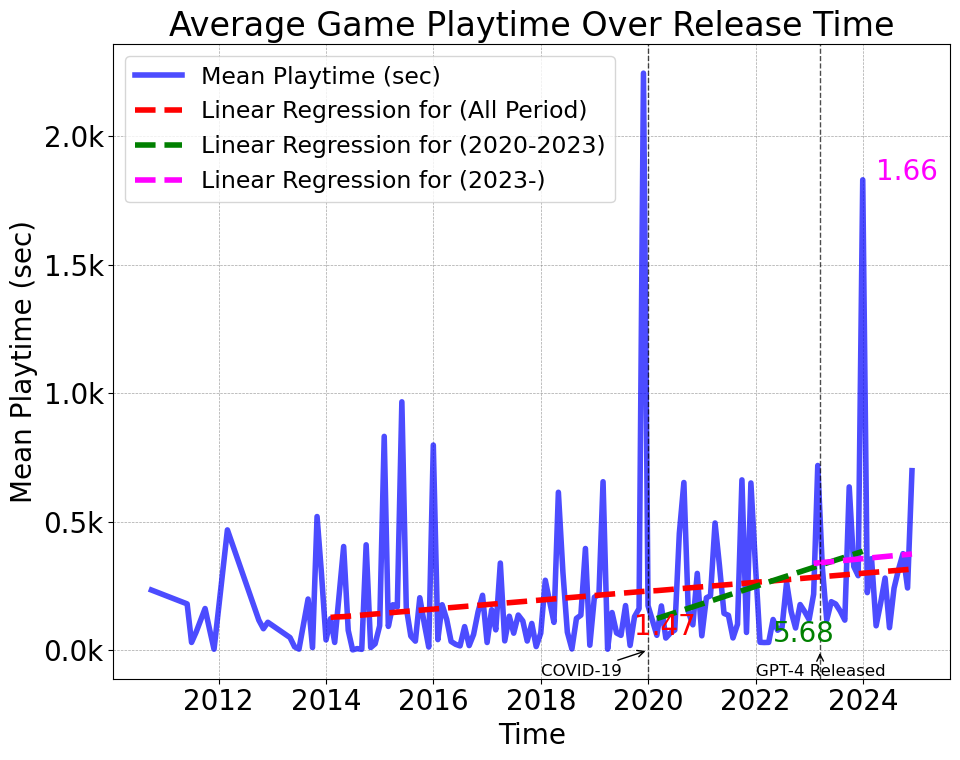

In [42]:
df = pd.read_csv("steamspy_crawl_table_cleaned.csv")

# Filter data from 2004 onwards
df['Release date'] = pd.to_datetime(df['Release date'])
df = df[df['Release date'].dt.year >= 2010]
# drop rows with null playtime
df = df.dropna(subset=['Median Playtime (sec)'])
#drop rows with 0 playtime
df = df[df['Median Playtime (sec)'] > 0]

df['Release date'] = pd.to_datetime(df['Release date'])
print(df.info())


# Set Release date as the index
df.set_index('Release date', inplace=True)

# Count the number of elements per month
df_monthly = df.resample('M')['Median Playtime (sec)'].mean().reset_index(name='feature')
df_monthly = df_monthly.dropna()

# Compute the cumulative total
# df_monthly['average game score'] = df_monthly['Metascore'].mean()
print(df_monthly.head(10))
# Create a function to fit and plot linear regression
def plot_with_regression_cumulative(df, label, color, start_date=None, end_date=None):
    # Filter data by date range
    filtered_df = df[(df['Release date'] >= start_date) & (df['Release date'] <= end_date)] if start_date and end_date else df
    x = np.arange(len(filtered_df)).reshape(-1, 1)  # Convert index to sequential numbers
    y = filtered_df['feature'].values.reshape(-1, 1)

    # Fit the regression model
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0][0]
    mid_date = filtered_df['Release date'].iloc[len(filtered_df) // 2]
    mid_cumulative = filtered_df['feature'].iloc[len(filtered_df) // 2]
    plt.text(mid_date+pd.Timedelta(days=90), mid_cumulative, f"{slope:.2f}", color=color, fontsize=20)
    # Plot the regression line
    plt.plot(filtered_df['Release date'], y_pred, label=f"Linear Regression for ({label})", color=color, linestyle="--",linewidth=4)

# Plot the cumulative data
plt.figure(figsize=(10, 8))
plt.plot(df_monthly['Release date'], df_monthly['feature'], label="Mean Playtime (sec)", color="blue", alpha=0.7, linewidth=4)
plt.rcParams.update({'font.size': 20})
# Plot regression lines
plot_with_regression_cumulative(df_monthly, "All Period", "red", "2014-01-01", "2024-12-31")
plot_with_regression_cumulative(df_monthly, "2020-2023", "green", "2020-01-01", "2023-12-31")
plot_with_regression_cumulative(df_monthly, "2023-", "magenta", "2023-01-01", "2024-12-31")
from matplotlib.ticker import FuncFormatter
def yaxis_formatter(x, _):
    return f"{x / 1000:.1f}k"  # Convert to thousands
plt.gca().yaxis.set_major_formatter(FuncFormatter(yaxis_formatter))
# Formatting the plot
plt.title("Average Game Playtime Over Release Time")
plt.xlabel("Time")
plt.ylabel("Mean Playtime (sec)")
plt.legend(fontsize=17 )
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.annotate(
    'COVID-19 ', 
    xy=(pd.Timestamp('2020-01-01'), 0),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2018-01-01'), -100),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=12
)
plt.annotate(
    'GPT-4 Released', 
    xy=(pd.Timestamp('2023-03-14'), 0),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2022-01-01'), -100),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=12
)
plt.axvline(x=pd.Timestamp('2020-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(x=pd.Timestamp('2023-03-14'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.tight_layout()

#save the plot
plt.savefig("average play time.png")

# Show the plot
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 46618 entries, 0 to 58492
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   #                      46618 non-null  int64         
 1   Game                   46618 non-null  object        
 2   Release date           46618 non-null  datetime64[ns]
 3   Price                  46618 non-null  float64       
 4   Owners                 46618 non-null  int64         
 5   Developer(s)           46618 non-null  object        
 6   Publisher(s)           46618 non-null  object        
 7   Median Playtime (sec)  46618 non-null  int64         
 8   Metascore              2080 non-null   float64       
 9   Sales                  46618 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 3.9+ MB
None
  Release date    feature
0   2010-01-31   4.800000
1   2010-02-28   5.666667
2   2010-03-31   9.33333

C:\Users\jakej\AppData\Local\Temp\ipykernel_44916\2633188648.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M')['Sales'].mean().reset_index(name='feature')


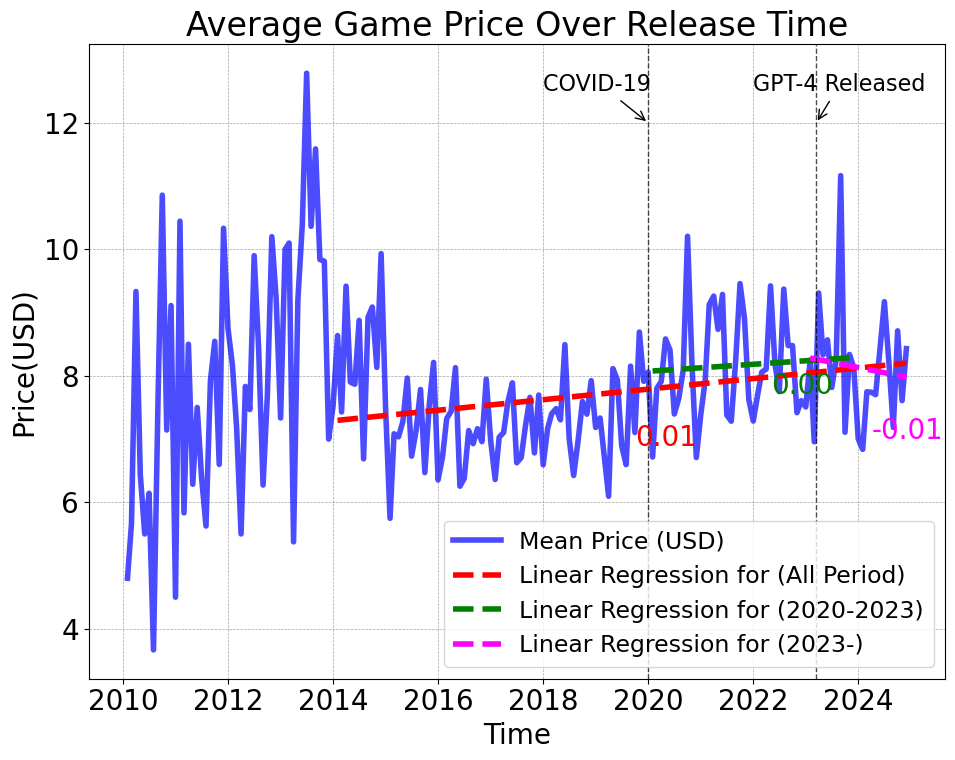

In [49]:
df = pd.read_csv("steamspy_crawl_table_cleaned.csv")

# Filter data from 2004 onwards
df['Release date'] = pd.to_datetime(df['Release date'])
df = df[df['Release date'].dt.year >= 2010]
# drop rows with null price
df = df.dropna(subset=['Price'])
#drop rows with 0 price
df = df[df['Price'] > 0]
# drop rows with null owners
df = df.dropna(subset=['Owners'])

df = df[df['Owners'] > 0]
df["Sales"]=df["Price"]

df['Release date'] = pd.to_datetime(df['Release date'])
print(df.info())


# Set Release date as the index
df.set_index('Release date', inplace=True)

# Count the number of elements per month
df_monthly = df.resample('M')['Sales'].mean().reset_index(name='feature')
df_monthly = df_monthly.dropna()

# Compute the cumulative total
# df_monthly['average game score'] = df_monthly['Metascore'].mean()
print(df_monthly.head(10))
# Create a function to fit and plot linear regression
def plot_with_regression_cumulative(df, label, color, start_date=None, end_date=None):
    # Filter data by date range
    filtered_df = df[(df['Release date'] >= start_date) & (df['Release date'] <= end_date)] if start_date and end_date else df
    x = np.arange(len(filtered_df)).reshape(-1, 1)  # Convert index to sequential numbers
    y = filtered_df['feature'].values.reshape(-1, 1)

    # Fit the regression model
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0][0]
    mid_date = filtered_df['Release date'].iloc[len(filtered_df) // 2]
    mid_cumulative = filtered_df['feature'].iloc[len(filtered_df) // 2]
    plt.text(mid_date+pd.Timedelta(days=90), mid_cumulative, f"{slope:.2f}", color=color, fontsize=20)
    # Plot the regression line
    plt.plot(filtered_df['Release date'], y_pred, label=f"Linear Regression for ({label})", color=color, linestyle="--",linewidth=4)

# Plot the cumulative data
plt.figure(figsize=(10, 8))
plt.plot(df_monthly['Release date'], df_monthly['feature'], label="Mean Price (USD)", color="blue", alpha=0.7, linewidth=4)

# Plot regression lines
plot_with_regression_cumulative(df_monthly, "All Period", "red", "2014-01-01", "2024-12-31")
plot_with_regression_cumulative(df_monthly, "2020-2023", "green", "2020-01-01", "2023-12-31")
plot_with_regression_cumulative(df_monthly, "2023-", "magenta", "2023-01-01", "2024-12-31")

# Formatting the plot
plt.title("Average Game Price Over Release Time")
plt.xlabel("Time")
plt.ylabel("Price(USD)")
plt.legend(fontsize=17 )
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.annotate(
    'COVID-19 ', 
    xy=(pd.Timestamp('2020-01-01'), 12),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2018-01-01'),12.5),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=16
)
plt.annotate(
    'GPT-4 Released', 
    xy=(pd.Timestamp('2023-03-14'), 12),  # Ensure xy uses a datetime object
    xytext=(pd.Timestamp('2022-01-01'), 12.5),  # Ensure xytext uses a datetime object
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=16
)
plt.axvline(x=pd.Timestamp('2020-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(x=pd.Timestamp('2023-03-14'), color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.tight_layout()

#save the plot
plt.savefig("average sales.png")

# Show the plot
plt.show()